In [15]:
import torch, cv2, os, sys, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from ModelZoo.utils import load_as_tensor, Tensor2PIL, PIL2Tensor, _add_batch_one
from ModelZoo import get_model, load_model, print_network
from SaliencyModel.utils import vis_saliency, vis_saliency_kde, click_select_position, grad_abs_norm, grad_norm, prepare_images, make_pil_grid, blend_input
from SaliencyModel.utils import cv2_to_pil, pil_to_cv2, gini
from SaliencyModel.attributes import attr_grad
from SaliencyModel.BackProp import I_gradient, attribution_objective, Path_gradient
from SaliencyModel.BackProp import saliency_map_PG as saliency_map
from SaliencyModel.BackProp import GaussianBlurPath
from SaliencyModel.utils import grad_norm, IG_baseline, interpolation, isotropic_gaussian_kernel

In [16]:
import math
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint

from basicsr.utils.registry import ARCH_REGISTRY
from basicsr.archs.arch_util import to_2tuple, trunc_normal_

from einops import rearrange

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    From: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/drop.py
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0], ) + (1, ) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).

    From: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/drop.py
    """

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class ChannelAttention(nn.Module):
    """Channel attention used in RCAN.
    Args:
        num_feat (int): Channel number of intermediate features.
        squeeze_factor (int): Channel squeeze factor. Default: 16.
    """

    def __init__(self, num_feat, squeeze_factor=16):
        super(ChannelAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(num_feat, num_feat // squeeze_factor, 1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_feat // squeeze_factor, num_feat, 1, padding=0),
            nn.Sigmoid())

    def forward(self, x):
        y = self.attention(x)
        return x * y


class CAB(nn.Module):

    def __init__(self, num_feat, compress_ratio=3, squeeze_factor=30):
        super(CAB, self).__init__()

        self.cab = nn.Sequential(
            nn.Conv2d(num_feat, num_feat // compress_ratio, 3, 1, 1),
            nn.GELU(),
            nn.Conv2d(num_feat // compress_ratio, num_feat, 3, 1, 1),
            ChannelAttention(num_feat, squeeze_factor)
            )

    def forward(self, x):
        return self.cab(x)


class Mlp(nn.Module):

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (b, h, w, c)
        window_size (int): window size

    Returns:
        windows: (num_windows*b, window_size, window_size, c)
    """
    b, h, w, c = x.shape
    x = x.view(b, h // window_size, window_size, w // window_size, window_size, c)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, c)
    return windows


def window_reverse(windows, window_size, h, w):
    """
    Args:
        windows: (num_windows*b, window_size, window_size, c)
        window_size (int): Window size
        h (int): Height of image
        w (int): Width of image

    Returns:
        x: (b, h, w, c)
    """
    b = int(windows.shape[0] / (h * w / window_size / window_size))
    x = windows.view(b, h // window_size, w // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(b, h, w, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, rpi, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*b, n, c)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        b_, n, c = x.shape
        qkv = self.qkv(x).reshape(b_, n, 3, self.num_heads, c // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[rpi.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nw = mask.shape[0]
            attn = attn.view(b_ // nw, nw, self.num_heads, n, n) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, n, n)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(b_, n, c)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class HAB(nn.Module):
    r""" Hybrid Attention Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self,
                 dim,
                 input_resolution,
                 num_heads,
                 window_size=7,
                 shift_size=0,
                 compress_ratio=3,
                 squeeze_factor=30,
                 conv_scale=0.01,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, 'shift_size must in 0-window_size'

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size=to_2tuple(self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop)

        self.conv_scale = conv_scale
        self.conv_block = CAB(num_feat=dim, compress_ratio=compress_ratio, squeeze_factor=squeeze_factor)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, x_size, rpi_sa, attn_mask):
        h, w = x_size
        b, _, c = x.shape
        # assert seq_len == h * w, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(b, h, w, c)

        # Conv_X
        conv_x = self.conv_block(x.permute(0, 3, 1, 2))
        conv_x = conv_x.permute(0, 2, 3, 1).contiguous().view(b, h * w, c)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
            attn_mask = attn_mask
        else:
            shifted_x = x
            attn_mask = None

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nw*b, window_size, window_size, c
        x_windows = x_windows.view(-1, self.window_size * self.window_size, c)  # nw*b, window_size*window_size, c

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        attn_windows = self.attn(x_windows, rpi=rpi_sa, mask=attn_mask)

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, c)
        shifted_x = window_reverse(attn_windows, self.window_size, h, w)  # b h' w' c

        # reverse cyclic shift
        if self.shift_size > 0:
            attn_x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            attn_x = shifted_x
        attn_x = attn_x.view(b, h * w, c)

        # FFN
        x = shortcut + self.drop_path(attn_x) + conv_x * self.conv_scale
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: b, h*w, c
        """
        h, w = self.input_resolution
        b, seq_len, c = x.shape
        assert seq_len == h * w, 'input feature has wrong size'
        assert h % 2 == 0 and w % 2 == 0, f'x size ({h}*{w}) are not even.'

        x = x.view(b, h, w, c)

        x0 = x[:, 0::2, 0::2, :]  # b h/2 w/2 c
        x1 = x[:, 1::2, 0::2, :]  # b h/2 w/2 c
        x2 = x[:, 0::2, 1::2, :]  # b h/2 w/2 c
        x3 = x[:, 1::2, 1::2, :]  # b h/2 w/2 c
        x = torch.cat([x0, x1, x2, x3], -1)  # b h/2 w/2 4*c
        x = x.view(b, -1, 4 * c)  # b h/2*w/2 4*c

        x = self.norm(x)
        x = self.reduction(x)

        return x


class OCAB(nn.Module):
    # overlapping cross-attention block

    def __init__(self, dim,
                input_resolution,
                window_size,
                overlap_ratio,
                num_heads,
                qkv_bias=True,
                qk_scale=None,
                mlp_ratio=2,
                norm_layer=nn.LayerNorm
                ):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5
        self.overlap_win_size = int(window_size * overlap_ratio) + window_size

        self.norm1 = norm_layer(dim)
        self.qkv = nn.Linear(dim, dim * 3,  bias=qkv_bias)
        self.unfold = nn.Unfold(kernel_size=(self.overlap_win_size, self.overlap_win_size), stride=window_size, padding=(self.overlap_win_size-window_size)//2)

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((window_size + self.overlap_win_size - 1) * (window_size + self.overlap_win_size - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

        self.proj = nn.Linear(dim,dim)

        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=nn.GELU)

    def forward(self, x, x_size, rpi):
        h, w = x_size
        b, _, c = x.shape

        shortcut = x
        x = self.norm1(x)
        x = x.view(b, h, w, c)

        qkv = self.qkv(x).reshape(b, h, w, 3, c).permute(3, 0, 4, 1, 2) # 3, b, c, h, w
        q = qkv[0].permute(0, 2, 3, 1) # b, h, w, c
        kv = torch.cat((qkv[1], qkv[2]), dim=1) # b, 2*c, h, w

        # partition windows
        q_windows = window_partition(q, self.window_size)  # nw*b, window_size, window_size, c
        q_windows = q_windows.view(-1, self.window_size * self.window_size, c)  # nw*b, window_size*window_size, c

        kv_windows = self.unfold(kv) # b, c*w*w, nw
        kv_windows = rearrange(kv_windows, 'b (nc ch owh oww) nw -> nc (b nw) (owh oww) ch', nc=2, ch=c, owh=self.overlap_win_size, oww=self.overlap_win_size).contiguous() # 2, nw*b, ow*ow, c
        k_windows, v_windows = kv_windows[0], kv_windows[1] # nw*b, ow*ow, c

        b_, nq, _ = q_windows.shape
        _, n, _ = k_windows.shape
        d = self.dim // self.num_heads
        q = q_windows.reshape(b_, nq, self.num_heads, d).permute(0, 2, 1, 3) # nw*b, nH, nq, d
        k = k_windows.reshape(b_, n, self.num_heads, d).permute(0, 2, 1, 3) # nw*b, nH, n, d
        v = v_windows.reshape(b_, n, self.num_heads, d).permute(0, 2, 1, 3) # nw*b, nH, n, d

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[rpi.view(-1)].view(
            self.window_size * self.window_size, self.overlap_win_size * self.overlap_win_size, -1)  # ws*ws, wse*wse, nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, ws*ws, wse*wse
        attn = attn + relative_position_bias.unsqueeze(0)

        attn = self.softmax(attn)
        attn_windows = (attn @ v).transpose(1, 2).reshape(b_, nq, self.dim)

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, self.dim)
        x = window_reverse(attn_windows, self.window_size, h, w)  # b h w c
        x = x.view(b, h * w, self.dim)

        x = self.proj(x) + shortcut

        x = x + self.mlp(self.norm2(x))
        return x


class AttenBlocks(nn.Module):
    """ A series of attention blocks for one RHAG.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self,
                 dim,
                 input_resolution,
                 depth,
                 num_heads,
                 window_size,
                 compress_ratio,
                 squeeze_factor,
                 conv_scale,
                 overlap_ratio,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.,
                 norm_layer=nn.LayerNorm,
                 downsample=None,
                 use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            HAB(
                dim=dim,
                input_resolution=input_resolution,
                num_heads=num_heads,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2,
                compress_ratio=compress_ratio,
                squeeze_factor=squeeze_factor,
                conv_scale=conv_scale,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop,
                attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer) for i in range(depth)
        ])

        # OCAB
        self.overlap_attn = OCAB(
                            dim=dim,
                            input_resolution=input_resolution,
                            window_size=window_size,
                            overlap_ratio=overlap_ratio,
                            num_heads=num_heads,
                            qkv_bias=qkv_bias,
                            qk_scale=qk_scale,
                            mlp_ratio=mlp_ratio,
                            norm_layer=norm_layer
                            )

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, x_size, params):
        for blk in self.blocks:
            x = blk(x, x_size, params['rpi_sa'], params['attn_mask'])

        x = self.overlap_attn(x, x_size, params['rpi_oca'])

        if self.downsample is not None:
            x = self.downsample(x)
        return x


class RHAG(nn.Module):
    """Residual Hybrid Attention Group (RHAG).

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self,
                 dim,
                 input_resolution,
                 depth,
                 num_heads,
                 window_size,
                 compress_ratio,
                 squeeze_factor,
                 conv_scale,
                 overlap_ratio,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.,
                 norm_layer=nn.LayerNorm,
                 downsample=None,
                 use_checkpoint=False,
                 img_size=224,
                 patch_size=4,
                 resi_connection='1conv'):
        super(RHAG, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = AttenBlocks(
            dim=dim,
            input_resolution=input_resolution,
            depth=depth,
            num_heads=num_heads,
            window_size=window_size,
            compress_ratio=compress_ratio,
            squeeze_factor=squeeze_factor,
            conv_scale=conv_scale,
            overlap_ratio=overlap_ratio,
            mlp_ratio=mlp_ratio,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            drop=drop,
            attn_drop=attn_drop,
            drop_path=drop_path,
            norm_layer=norm_layer,
            downsample=downsample,
            use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == 'identity':
            self.conv = nn.Identity()

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim, norm_layer=None)

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim, norm_layer=None)

    def forward(self, x, x_size, params):
        return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size, params), x_size))) + x


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # b Ph*Pw c
        if self.norm is not None:
            x = self.norm(x)
        return x


class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        x = x.transpose(1, 2).contiguous().view(x.shape[0], self.embed_dim, x_size[0], x_size[1])  # b Ph*Pw c
        return x


class Upsample(nn.Sequential):
    """Upsample module.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class HAT(nn.Module):
    r""" Hybrid Attention Transformer
        A PyTorch implementation of : `Activating More Pixels in Image Super-Resolution Transformer`.
        Some codes are based on SwinIR.
    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self,
                 img_size=64,
                 patch_size=1,
                 in_chans=3,
                 embed_dim=96,
                 depths=(6, 6, 6, 6),
                 num_heads=(6, 6, 6, 6),
                 window_size=7,
                 compress_ratio=3,
                 squeeze_factor=30,
                 conv_scale=0.01,
                 overlap_ratio=0.5,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm,
                 ape=False,
                 patch_norm=True,
                 use_checkpoint=False,
                 upscale=2,
                 img_range=1.,
                 upsampler='',
                 resi_connection='1conv',
                 **kwargs):
        super(HAT, self).__init__()

        self.window_size = window_size
        self.shift_size = window_size // 2
        self.overlap_ratio = overlap_ratio

        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler

        # relative position index
        relative_position_index_SA = self.calculate_rpi_sa()
        relative_position_index_OCA = self.calculate_rpi_oca()
        self.register_buffer('relative_position_index_SA', relative_position_index_SA)
        self.register_buffer('relative_position_index_OCA', relative_position_index_OCA)

        # ------------------------- 1, shallow feature extraction ------------------------- #
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        # ------------------------- 2, deep feature extraction ------------------------- #
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=embed_dim,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=embed_dim,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build Residual Hybrid Attention Groups (RHAG)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RHAG(
                dim=embed_dim,
                input_resolution=(patches_resolution[0], patches_resolution[1]),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                compress_ratio=compress_ratio,
                squeeze_factor=squeeze_factor,
                conv_scale=conv_scale,
                overlap_ratio=overlap_ratio,
                mlp_ratio=self.mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
                norm_layer=norm_layer,
                downsample=None,
                use_checkpoint=use_checkpoint,
                img_size=img_size,
                patch_size=patch_size,
                resi_connection=resi_connection)
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == 'identity':
            self.conv_after_body = nn.Identity()

        # ------------------------- 3, high quality image reconstruction ------------------------- #
        if self.upsampler == 'pixelshuffle':
            # for classical SR
            self.conv_before_upsample = nn.Sequential(
                nn.Conv2d(embed_dim, num_feat, 3, 1, 1), nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def calculate_rpi_sa(self):
        # calculate relative position index for SA
        coords_h = torch.arange(self.window_size)
        coords_w = torch.arange(self.window_size)
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size - 1
        relative_coords[:, :, 0] *= 2 * self.window_size - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        return relative_position_index

    def calculate_rpi_oca(self):
        # calculate relative position index for OCA
        window_size_ori = self.window_size
        window_size_ext = self.window_size + int(self.overlap_ratio * self.window_size)

        coords_h = torch.arange(window_size_ori)
        coords_w = torch.arange(window_size_ori)
        coords_ori = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, ws, ws
        coords_ori_flatten = torch.flatten(coords_ori, 1)  # 2, ws*ws

        coords_h = torch.arange(window_size_ext)
        coords_w = torch.arange(window_size_ext)
        coords_ext = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, wse, wse
        coords_ext_flatten = torch.flatten(coords_ext, 1)  # 2, wse*wse

        relative_coords = coords_ext_flatten[:, None, :] - coords_ori_flatten[:, :, None]   # 2, ws*ws, wse*wse

        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # ws*ws, wse*wse, 2
        relative_coords[:, :, 0] += window_size_ori - window_size_ext + 1  # shift to start from 0
        relative_coords[:, :, 1] += window_size_ori - window_size_ext + 1

        relative_coords[:, :, 0] *= window_size_ori + window_size_ext - 1
        relative_position_index = relative_coords.sum(-1)
        return relative_position_index

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        h, w = x_size
        img_mask = torch.zeros((1, h, w, 1))  # 1 h w 1
        h_slices = (slice(0, -self.window_size), slice(-self.window_size,
                                                       -self.shift_size), slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size), slice(-self.window_size,
                                                       -self.shift_size), slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nw, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])
        attn_mask = self.calculate_mask(x_size).to(x.device)
        params = {'attn_mask': attn_mask, 'rpi_sa': self.relative_position_index_SA, 'rpi_oca': self.relative_position_index_OCA}

        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        i=0
        for layer in self.layers:
            if i<=4:
                x = layer(x, x_size, params)
                i+=1

        x = self.norm(x)  # b seq_len c
        feature_map = self.patch_unembed(x, x_size)  # 这里获取特徵图

        return feature_map

    def forward(self, x, return_feature_map=False):
        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        feature_maps = None  # 初始化变量以存储特徵图
        if self.upsampler == 'pixelshuffle':
            x = self.conv_first(x)
            feature_maps = self.forward_features(x)  # 获取初始的特徵图
            
            # 应用conv_after_body来获得需要的特徵图
            post_feature_maps = self.conv_after_body(feature_maps)  # 在这一步捕获特徵图

            if return_feature_map:
                # 如果只需要特徵图，则在这里返回
                return None, post_feature_maps
            
            # 如果还需要进行重建，继续执行剩余的操作
            x = post_feature_maps + x  # 注意：此处使用了修改后的特徵图
            x = self.conv_before_upsample(x)
            reconstructed = self.conv_last(self.upsample(x))
        else:
            # 如果你有其他的重建流程，请在这里处理
            reconstructed = None

        if reconstructed is not None:
            reconstructed = reconstructed / self.img_range + self.mean

        # 根据return_feature_map的值，可能返回None和修改后的特徵图，或者是重建图像和特徵图
        return reconstructed, post_feature_maps


In [17]:
model = HAT(upscale=4, in_chans=3,  img_size= 64, window_size= 16, compress_ratio= 3,squeeze_factor= 30,
                        conv_scale= 0.01, overlap_ratio= 0.5, img_range= 1., depths= [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
                        embed_dim= 180, num_heads= [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], gc= 32,
                        mlp_ratio= 2, upsampler= 'pixelshuffle', resi_connection= '1conv')

state_dict_path = '/work/u1657859/ming0531/DRCT/FeatureVisualization_map/LAM_Demo/ModelZoo/models/HAT_L_155000.pth'
state_dict = torch.load(state_dict_path, map_location='cpu')

model.load_state_dict(state_dict['params_ema'], strict=True)

<All keys matched successfully>

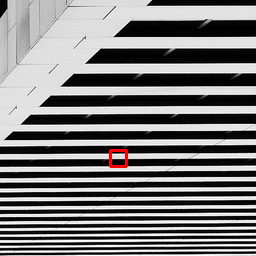

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import torch

window_size = 16  # Define windoes_size of D
img_lr, img_hr = prepare_images('/work/u1657859/ming0531/DRCT/FeatureVisualization/LAM_Demo/test_images/4.png')  # Change this image name
tensor_lr = PIL2Tensor(img_lr)[:3] ; tensor_hr = PIL2Tensor(img_hr)[:3]
cv2_lr = np.moveaxis(tensor_lr.numpy(), 0, 2) ; cv2_hr = np.moveaxis(tensor_hr.numpy(), 0, 2)
w = 110  # The x coordinate of your select patch, 125 as an example
h = 150  # The y coordinate of your select patch, 160 as an example
         # And check the red box
         # Is your selected patch this one? If not, adjust the `w` and `h`.


draw_img = pil_to_cv2(img_hr)
cv2.rectangle(draw_img, (w, h), (w + window_size, h + window_size), (0, 0, 255), 2)
position_pil = cv2_to_pil(draw_img)
position_pil

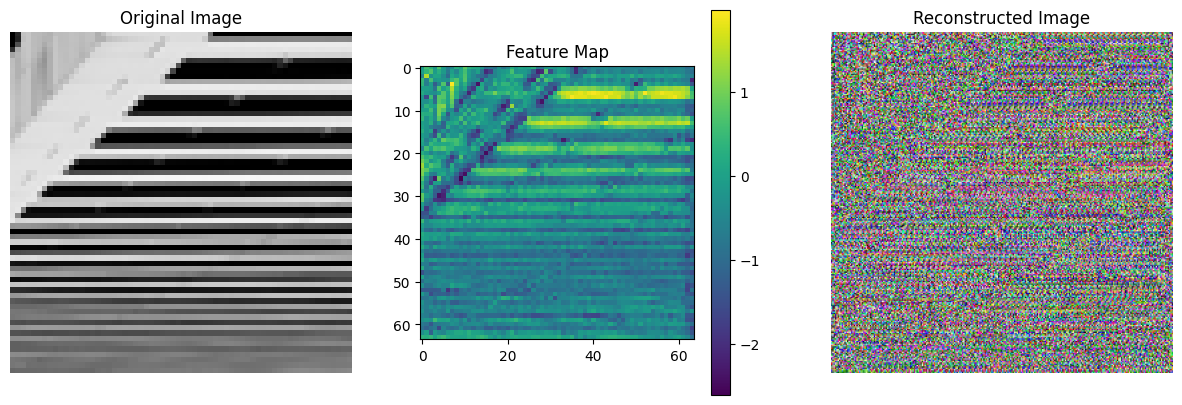

In [19]:
model.eval()  # 确保模型处于评估模式

with torch.no_grad():
    _, feature_maps = model(tensor_lr, return_feature_map=True)
with torch.no_grad():
    reconstructed, _ = model(tensor_lr, return_feature_map=False)
plt.figure(figsize=(15, 5))  # 调整整体图像大小


plt.subplot(1, 3, 1)  # 1行3列，这是第一个图像
plt.imshow(img_lr)
plt.title("Original Image")
plt.axis('off')  # 不显示坐标轴
# 可视化特徵图
# 选择一个特徵图进行展示，这里我们简单地选取第一个特徵图
feature_map_to_show = feature_maps[0, 0].cpu().numpy()  # 转换为 NumPy 数组并选择第一个特徵图
plt.subplot(1, 3, 2)  # 1行3列，这是第二个图像
# 因为特征图可能不是标准的RGB图像，所以使用灰度色彩映射来显示
plt.imshow(feature_map_to_show)
plt.title("Feature Map")
plt.colorbar()  # 显示色彩条

# 可视化重建图像
reconstructed_image = reconstructed[0].cpu().numpy()  # 转换为 NumPy 数组
reconstructed_image = np.transpose(reconstructed_image, (1, 2, 0))  # CHW -> HWC
reconstructed_image = (reconstructed_image * 255).astype(np.uint8)  # 缩放到 [0, 255] 范围并转换为 uint8
# 使用 matplotlib 显示图像
plt.subplot(1, 3, 3)  # 1行3列，这是第三个图像
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis('off')  # 不显示坐标轴
plt.show()

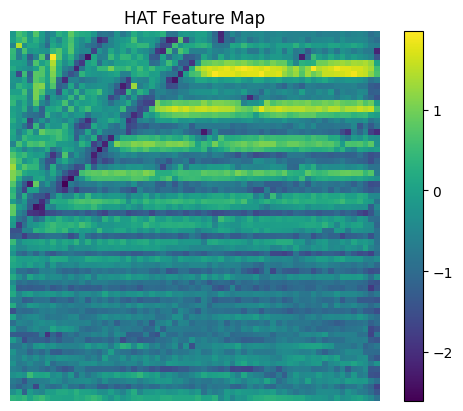

In [20]:
plt.imshow(feature_map_to_show, cmap='viridis')  # You can change the colormap if needed
plt.title("HAT Feature Map")
plt.colorbar()  # Shows color bar
plt.axis('off')  # Hides the coordinate axes
plt.show()

In [21]:
feature_map_to_show
max_value = np.max(feature_map_to_show)
median_value = np.median(feature_map_to_show)
min_value = np.min(feature_map_to_show)

print("Max Value:", max_value)
print("Median Value:", median_value)
print("Min Value:", min_value)

Max Value: 1.9720144
Median Value: -0.46972787
Min Value: -2.6110675
